In [1]:
import numpy as np
from numpy import genfromtxt
import pandas as pd
from numpy.linalg import matrix_power
import matplotlib.pyplot as plt

def ReLu(inp):
    z = np.zeros(inp.shape)
    return np.maximum(inp, 0)

In [2]:
train = np.genfromtxt('./DataSet2/Reduced_Train_Data.csv', delimiter = ',')
trainL = np.genfromtxt('./DataSet2/trainLabels.csv', delimiter = ',')
testData = np.genfromtxt('./DataSet2/Reduced_Test_Data.csv', delimiter = ',')
testLabels = np.genfromtxt('./DataSet2/testLabels.csv', delimiter = ',')
train -= np.mean(train, axis = 0, keepdims=True)
train /= np.std(train, axis =0, keepdims=True)
testData -= np.mean(testData, axis = 0, keepdims=True)
testData /= np.std(testData, axis =0, keepdims=True)

In [3]:
trainL = trainL.astype(int)
trainEncodeL = np.zeros((trainL.size, trainL.max()+1))
trainEncodeL[np.arange(trainL.size),trainL] = 1
testLabels = testLabels.astype(int)
testEncodeLabels = np.zeros((testLabels.size, testLabels.max()+1))
testEncodeLabels[np.arange(testLabels.size), testLabels] = 1

In [4]:
length = len(train)
indices = np.random.permutation(train.shape[0])
trainingIdx, validIdx = indices[:int(0.8*length)], indices[int(0.8*length):]
trainData, validation = train[trainingIdx,:], train[validIdx,:]
trainLabels, validationLabels = trainL[trainingIdx], trainL[validIdx]
trainEncodeLabels, validationEncodeLabel = trainEncodeL[trainingIdx], trainEncodeL[validIdx]

In [5]:
class NeuralNetwork:
    def __init__(self):
        self.lr = 0.01
        
    def initWeight(self, hiddenNodes):
        self.hiddenNodes = hiddenNodes
        self.weight1 = np.random.rand(128, self.hiddenNodes)
        self.weight2 = np.random.rand( self.hiddenNodes, 10)
        self.bias1 = np.random.rand(1, self.hiddenNodes)
        self.bias2 = np.random.rand(1, 10)
        
    def inOut(self, x, y):
        self.input = x
        self.y = y
        self.predict = np.zeros(self.y.shape)
        
    def saveWeight(self, path):
        np.savetxt(path + './weight1.csv', self.weight1, delimiter = ',')
        np.savetxt(path + './weight2.csv', self.weight2, delimiter = ',')
        np.savetxt(path + './bias1.csv', self.bias1, delimiter = ',')
        np.savetxt(path + './bias2.csv', self.bias2, delimiter = ',')

    def loadWeight(self, path):
        self.weight1 = genfromtxt( path + 'weight1.csv', delimiter = ',')
        self.weight2 = genfromtxt( path + 'weight2.csv', delimiter = ',')
        self.bias1 = genfromtxt( path + 'bias1.csv', delimiter = ',')
        self.bias2 = genfromtxt( path + 'bias2.csv', delimiter = ',')
        
    def forward(self, activationFunc, inp = 'none'):
        if inp == 'none':
            inp = self.input
        if activationFunc == 'tanh':
            self.hidLayer = np.tanh(np.matmul( inp, self.weight1) + self.bias1)
            self.predict = np.tanh(np.matmul(self.hidLayer, self.weight2) + self.bias2)
        
        elif activationFunc == 'Relu':
            self.hidLayer = relu(np.matmul( inp, self.weight1) + self.bias1)
            self.predict = relu(np.matmul(self.hidLayer, self.weight2) + self.bias2)
        
        return np.argmax(self.predict)
        
    def backPropagate(self):
        temp = np.multiply((self.predict - self.y), (np.ones((1,10), dtype =float) - np.power( np.tanh(self.predict),2)))
        dweight2 = self.lr * 0.2 * np.matmul( np.tanh(self.hidLayer).T, temp)
        t = np.ones((1, self.hiddenNodes), dtype =float) - np.power(np.tanh(self.hidLayer), 2)
        dweight1 = self.lr * 0.2 * np.matmul(self.input.T, (np.multiply(t, np.matmul(temp, self.weight2.T))))
        self.bias2 = self.bias2 - self.lr * 0.2 * temp
        self.bias1 = self.bias1 - self.lr * 0.2 * (np.multiply(t, np.matmul(temp ,self.weight2.T)))
        self.weight1 = self.weight1 - dweight1
        self.weight2 = self.weight2 - dweight2

In [6]:
def plotLineChart(x, y1, y2, label1, label2, xlabel, ylabel, title):
    plt.plot(x, y1, label = label1, c = 'c') 
    plt.plot(x, y2, label = label2, c = 'm') 
    plt.xlabel(xlabel) 
    plt.ylabel(ylabel) 
    plt.title(title) 
    plt.legend() 
    plt.show()

def loss(pred, org):
    return 0.1*(np.power(pred - org, 2).sum())

def train(nn):
    for r in range(len(trainData)):
        nn.inOut( trainData[[r],:], trainEncodeLabels[r])
        nn.forward('tanh')
        nn.backPropagate()
        
def evaluate(nn, epoch):
    tt = 0
    vt = 0
    trainLoss = 0
    validLoss = 0
    for i in range(len(trainData)):
        pred = nn.forward('tanh', trainData[[i],:])
        if( pred == trainLabels[i]):
            tt += 1
        trainLoss += loss(pred, trainEncodeLabels[i])
        
    for i in range(len(validation)):
        pred = nn.forward('tanh', validation[[i],:])
        if( pred == validationLabels[i]):
            vt += 1
        validLoss += loss(pred, validationEncodeLabel[i])
#     print('Epoch Num: ', epoch, '\n Total Loss-Train Data: ', trainLoss/len(trainData), ' Accuracy: ', tt/len(trainData))
#     print(' Total Loss-Valid Data: ', validLoss/len(validation), ' Accuracy: ', vt/len(validation))
          
    return [trainLoss/len(trainData), tt/len(trainData), validLoss/len(validation), vt/len(validation)]

In [7]:
def showResult(nn):
    tt = 0
    testLoss = 0
    for i in range(len(testData)):
        pred = nn.forward('tanh', testData[[i],:])
        if( pred.astype(int) == testLabels[i].astype(int)):
            tt += 1
        testLoss += loss(pred, testEncodeLabels[i])
    print('Total Loss - Test Data: ', testLoss, ' Accuracy: ', tt/len(testData))

def fit(nn, epoch):
    trainLoss = []
    validLoss = []
    trainAcc = []
    validAcc = []
    for i in range(epoch):
        train(nn)
        out = evaluate(nn, i)
        trainLoss += [out[0]]
        trainAcc += [out[1]]
        validLoss += [out[2]]
        validAcc += [out[3]]
    plotLineChart(range(1, epoch+1), trainLoss, validLoss, 'Train', 'Validation', "Num of Epoch", "Average Loss", "Average Loss per Epoch")
    plotLineChart(range(1, epoch+1), trainAcc, validAcc, 'Train', 'Validation', "Num of Epoch", "Accuracy", "Accuracy per Epoch")
    showResult(nn)

/home/shakiba/.local/lib/python3.5/site-packages/ipykernel_launcher.py:30: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


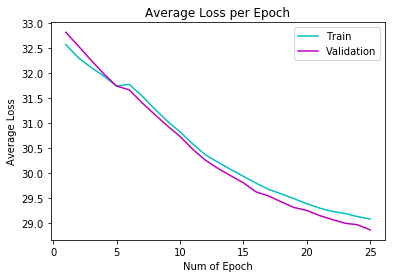

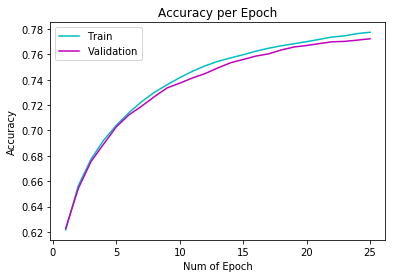

Total Loss - Test Data:  292382.79999999725  Accuracy:  0.7652


In [8]:
nn1 = NeuralNetwork()
nn1.initWeight(150)
# nn1.loadWeight('./')
fit(nn1, 25)
nn1.saveWeight('./')

/home/shakiba/.local/lib/python3.5/site-packages/ipykernel_launcher.py:30: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


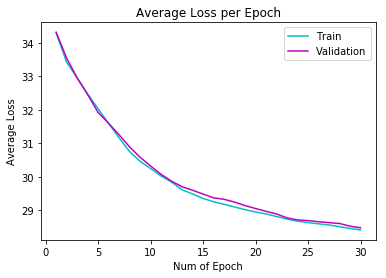

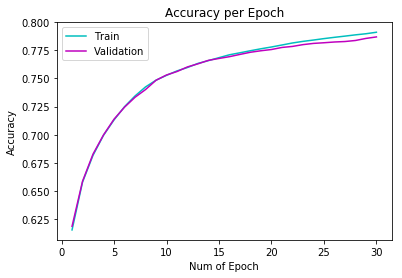

Total Loss - Test Data:  286020.799999998  Accuracy:  0.7782


In [9]:
nn2 = NeuralNetwork()
nn2.initWeight(100)
fit(nn2, 30)

/home/shakiba/.local/lib/python3.5/site-packages/ipykernel_launcher.py:30: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


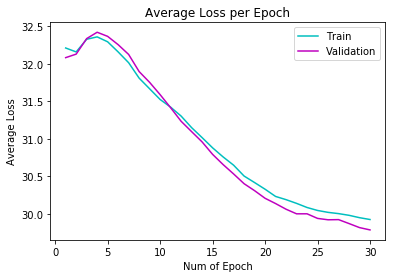

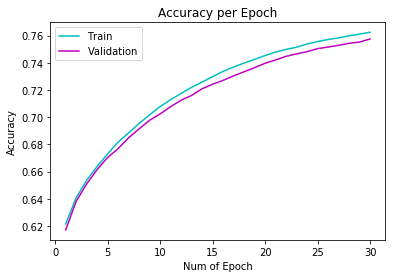

Total Loss - Test Data:  299021.5999999974  Accuracy:  0.7514


In [10]:
nn3 = NeuralNetwork()
nn3.initWeight(300)
fit(nn3, 30)